# Baseline Model for Endangered Language Classification

**Description**: This notebook establishes a baseline for classification performance using the **majority class** prediction.  
We'll evaluate both the **granular level labels** and the **grouped level labels** to compare effectiveness.
- Granular labels (individual endangered categories)
- Grouped labels (combined into broader categories like "At Risk" or "Highly Endangered").

We report:
- Accuracy (train/validation/test)
- Confusion matrix
- Precision, Recall, F1-score

This baseline helps us understand how much gain we get from more sophisticated models like gradient boosting or ensemble.


In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report
import warnings
warnings.filterwarnings('ignore')

### Step 1: Load the final dataset, which is now a parquet file

In [2]:
df = pd.read_parquet('Data Cleaning/final_dataset2.parquet')

### Step 2: Combine Endangered Levels (for grouped classification)

In [3]:
# Create a grouped version of the endangered levels
def combine_endangered_classes(level):
    if level in ['Severely Endangered', 'Critically Endangered']:
        return 'Highly Endangered'
    elif level in ['Threatened', 'Vulnerable', 'At risk']:
        return 'At Risk'
    else:
        return level

df_granular = df.copy()
df_grouped = df.copy()
df_grouped['level'] = df_grouped['level'].apply(combine_endangered_classes)

### Step 3: Train/Val/Test Split
We’ll evaluate the baseline using both the granular levels and grouped levels.

In [4]:
# Split the data (60/20/20)
def split_data(df, label_col):
    X_train, X_temp, y_train, y_temp = train_test_split(
        df, df[label_col],
        test_size=0.4, random_state=42, stratify=df[label_col]
    )
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp,
        test_size=0.5, random_state=42, stratify=y_temp
    )
    return X_train, X_val, X_test, y_train, y_val, y_test

# Granular split
X_train_g, X_val_g, X_test_g, y_train_g, y_val_g, y_test_g = split_data(df_granular, 'level')

# Grouped split
X_train_grp, X_val_grp, X_test_grp, y_train_grp, y_val_grp, y_test_grp = split_data(df_grouped, 'level')


### Step 4: Define Baseline Predictor
This baseline always predicts the most frequent class in the training set.


## Baseline Model (no tuning)

Granular levels  
- Training Accuracy: 26.0%  
- Validation Accuracy: 26.1%  
- Test Accuracy: 26.0%  
- *Notes:* The model always predicts the majority class ("Threatened"), leading to very low accuracy due to the number of distinct categories. This shows the importance of using more advanced models for meaningful predictions.

Grouped levels  
- Training Accuracy: 43.1%  
- Validation Accuracy: 43.0%  
- Test Accuracy: 43.0%  
- *Notes:* Accuracy improves when endangered levels are grouped into broader categories. Still, predicting the majority class ("At Risk") misses over half of the samples, emphasizing the value of more nuanced models like gradient boosting and ensembles.

In [5]:
def majority_class_baseline(y_train, y_val, y_test):
    """
    Predicts the majority class from the training data for all splits and returns accuracies.
    """
    majority_class = y_train.mode()[0]
    
    y_train_pred = [majority_class] * len(y_train)
    y_val_pred = [majority_class] * len(y_val)
    y_test_pred = [majority_class] * len(y_test)
    
    train_acc = accuracy_score(y_train, y_train_pred)
    val_acc = accuracy_score(y_val, y_val_pred)
    test_acc = accuracy_score(y_test, y_test_pred)
    
    return majority_class, train_acc, val_acc, test_acc

### Step 5: Evaluate Baseline Accuracy


In [6]:
# Granular levels
majority_g, acc_train_g, acc_val_g, acc_test_g = majority_class_baseline(y_train_g, y_val_g, y_test_g)

print("Granular Levels Baseline")
print(f"Majority Class: {majority_g}")
print(f"Training Accuracy:   {acc_train_g:.3f}")
print(f"Validation Accuracy: {acc_val_g:.3f}")
print(f"Test Accuracy:       {acc_test_g:.3f}")
print()

# Grouped levels
majority_grp, acc_train_grp, acc_val_grp, acc_test_grp = majority_class_baseline(y_train_grp, y_val_grp, y_test_grp)

print("Grouped Levels Baseline")
print(f"Majority Class: {majority_grp}")
print(f"Training Accuracy:   {acc_train_grp:.3f}")
print(f"Validation Accuracy: {acc_val_grp:.3f}")
print(f"Test Accuracy:       {acc_test_grp:.3f}")


Granular Levels Baseline
Majority Class: Threatened
Training Accuracy:   0.260
Validation Accuracy: 0.261
Test Accuracy:       0.260

Grouped Levels Baseline
Majority Class: At Risk
Training Accuracy:   0.431
Validation Accuracy: 0.430
Test Accuracy:       0.430


### Baseline Metrics Explanation
Because this baseline always predicts the majority class, its precision, recall, and F1 scores for minority classes are zero, and the confusion matrix is dominated by the majority class row and column. Thus, accuracy is the most informative metric here to demonstrate baseline performance. 

However, we will still include the confusion matrix and classification report below for completeness, to illustrate the limitations of this naive baseline.

#### Granular level

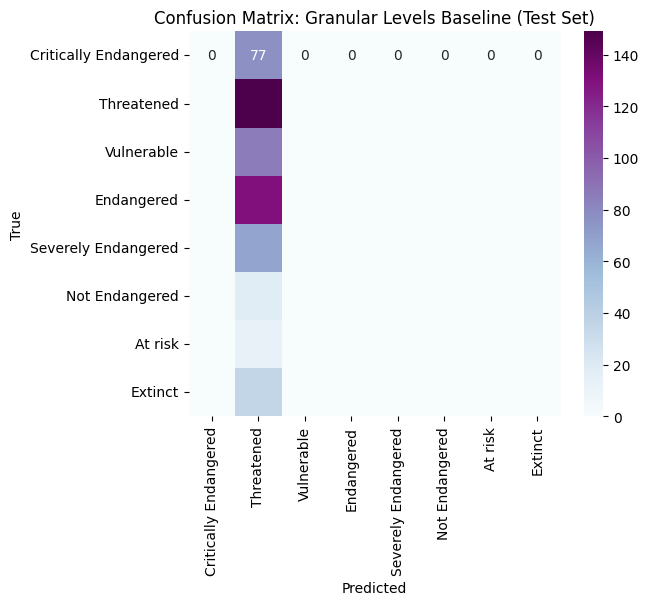

In [7]:
# Confusion martix example for granular test set baseline predictions
y_test_pred_baseline_g = [majority_g] * len(y_test_g)

cm_g = confusion_matrix(y_test_g, y_test_pred_baseline_g, labels=y_test_g.unique())

plt.figure(figsize=(6,5))
sns.heatmap(cm_g, annot=True, fmt='d', cmap='BuPu', xticklabels=y_test_g.unique(), yticklabels=y_test_g.unique())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix: Granular Levels Baseline (Test Set)')
plt.show()


The model always predicts the majority class "Threatened" regardless of the true class.

All true instances of other classes are misclassified as "Threatened," which explains why the confusion matrix has a single column filled with counts for the "Threatened" predicted class.

This leads to no correct predictions for any other class except for those actually labeled as "Threatened."

In [8]:
print("Classification Report: Granular Levels Baseline (Test Set)")
print(classification_report(y_test_g, y_test_pred_baseline_g, zero_division=0))

Classification Report: Granular Levels Baseline (Test Set)
                       precision    recall  f1-score   support

              At risk       0.00      0.00      0.00        13
Critically Endangered       0.00      0.00      0.00        77
           Endangered       0.00      0.00      0.00       130
              Extinct       0.00      0.00      0.00        35
       Not Endangered       0.00      0.00      0.00        18
  Severely Endangered       0.00      0.00      0.00        67
           Threatened       0.26      1.00      0.41       149
           Vulnerable       0.00      0.00      0.00        85

             accuracy                           0.26       574
            macro avg       0.03      0.12      0.05       574
         weighted avg       0.07      0.26      0.11       574



Accuracy is about 26%, meaning roughly one in four samples are correctly classified due to the frequency of the majority class.

Recall for "Threatened" is 1.0 (100%), meaning the model correctly identifies all "Threatened" instances.

Precision for "Threatened" is low (0.26), indicating many false positives since all other classes are predicted as "Threatened."

For all other classes, precision, recall, and F1 scores are 0.00, meaning the baseline model completely fails to identify any samples belonging to these minority classes.

#### Grouped level

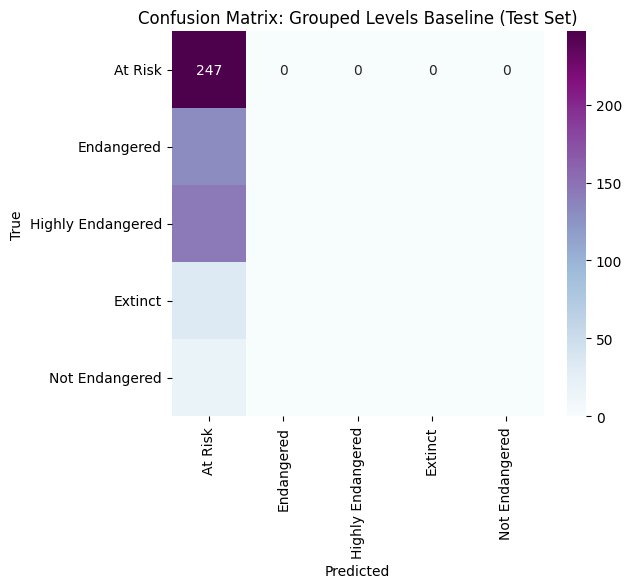

In [9]:
# Grouped level predictions and evaluation
y_test_pred_baseline_grp = [majority_grp] * len(y_test_grp)

# Confusion matrix
cm_grp = confusion_matrix(y_test_grp, y_test_pred_baseline_grp, labels=y_test_grp.unique())

plt.figure(figsize=(6,5))
sns.heatmap(cm_grp, annot=True, fmt='d', cmap='BuPu',
            xticklabels=y_test_grp.unique(), yticklabels=y_test_grp.unique())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix: Grouped Levels Baseline (Test Set)')
plt.show()

In [10]:
# Classification report
print("Classification Report: Grouped Levels Baseline (Test Set)")
print(classification_report(y_test_grp, y_test_pred_baseline_grp, zero_division=0))

Classification Report: Grouped Levels Baseline (Test Set)
                   precision    recall  f1-score   support

          At Risk       0.43      1.00      0.60       247
       Endangered       0.00      0.00      0.00       131
          Extinct       0.00      0.00      0.00        34
Highly Endangered       0.00      0.00      0.00       144
   Not Endangered       0.00      0.00      0.00        18

         accuracy                           0.43       574
        macro avg       0.09      0.20      0.12       574
     weighted avg       0.19      0.43      0.26       574



## Final Interpretation of Baseline Model
This baseline model clearly demonstrates the limitation of predicting only the majority class, as it can't distinguish between different endangered levels beyond the dominant category. This justifies the need for more sophisticated models that can use various features and patterns within the data to improve classification for all other minority classes.